## Variables

In [2]:
data_path = "/home/ieljamiy/RawData"

# 1. 2D Dataset

## 1.1 Functions

In [3]:
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import os
import numpy as np
import random
from pathlib import Path

### 1.1.1 Create dataset dict

In [11]:
def organ_mapper():
    label_dict = {
        0: "background",
        1: "spleen",
        2: "right kidney",
        3: "left kidney",
        4: "gallbladder",
        5: "esophagus",
        6: "liver",
        7: "stomach",
        8: "aorta",
        9: "inferior vena cava",
        10: "portal vein & splenic vein",
        11: "pancreas",
        12: "right adrenal gland",
        13: "left adrenal gland",
    }
    key_to_organ = label_dict
    organ_to_key = {v.lower(): k for k, v in label_dict.items()}
    return key_to_organ, organ_to_key


def transform_to_csv(data_root):
    """
    Transform the BTCV dataset to a csv file.
    Args:
        data_root (str): path to the BTCV dataset.

    Returns:
        annotations (list): list of dictionaries containing the images and their masks with a list of organs available in each scan.

    """

    annotations = []
    # images_dir = os.path.join(data_root, "imagesTr")
    # masks_dir = os.path.join(data_root, "labelsTr")
    # imgs = [images_dir + "/" + f for f in sorted(os.listdir(images_dir))]
    # masks = [masks_dir + "/" + f for f in sorted(os.listdir(masks_dir))]
    img_dir = os.path.join(data_path, "imagesTr")
    masks_dir = os.path.join(data_path, "labelsTr")
    imgs = Path(img_dir).glob("*.nii.gz")
    masks = Path(masks_dir).glob("*.nii.gz")

    for img_path, mask_path in zip(sorted(imgs), sorted(masks)):
        patient_id = img_path.stem.replace("_0000.nii.gz", "")  # e.g., 'case_0001'
        mask_nifti = nib.load(mask_path)
        mask_data = mask_nifti.get_fdata()
        organs = [int(organ) for organ in np.unique(mask_data).tolist()]
        annotations.append(
            {
                "patient_id": patient_id,
                "img_path": str(img_path),
                "mask_path": str(mask_path),
                "organs": organs,
            }
        )

    annotations_df = pd.DataFrame(annotations)
    # Save to CSV
    annotations_df.to_csv(os.path.join(data_root, "dataset.csv"), index=False, sep=",")

    return annotations

### 1.1.2 train & test split

In [18]:
def extract_slices(in_set, organs):
    out_set = []
    key_to_organ, organ_to_key = organ_mapper()
    for row in in_set:
        for organ in organs:
            organ_key = organ_to_key.get(organ)
            if organ_key is None:
                print(f"Organ {organ} not found in organ mapping. Skipping.")
                continue

            img_path = row["img_path"]
            mask_path = row["mask_path"]
            subject_organ = row["organs"]
            if organ_key not in subject_organ:
                continue

            mask = sitk.ReadImage(mask_path)
            mask_arr = sitk.GetArrayFromImage(mask)  # Shape: (Depth, Height, Width)

            slices_with_organ = np.any(mask_arr == organ_key, axis=(1, 2))
            slices_indices = np.where(slices_with_organ)[0].tolist()
            out_set.append(
                {
                    "patient_id": row["patient_id"],
                    "img_path": img_path,
                    "mask_path": mask_path,
                    "organ": organ,
                    "begin_slice": slices_indices[0],
                    "end_slice": slices_indices[-1],
                }
            )
    return out_set

In [19]:
def create_dataset(annotations, organs, data_len=27, train_size=24, seed=42):
    """
    Load a specific number of slices from the BTCV dataset.
    Args:
        n_slices (int): Number of slices to load.

    Returns:
        slices_df (list): List of loaded slices.
    """
    if seed is not None:
        random.seed(seed)
    # split the dataset to train and test sets
    # annotations_random = random.sample(annotations, data_len)
    # we using this just for debugging
    # annotations = pd.DataFrame(annotations)
    train_patients = [
        "img_018_0000.nii",
        "img_014_0000.nii",
        "img_011_0000.nii",
        "img_029_0000.nii",
        "img_022_0000.nii",
        "img_008_0000.nii",
        "img_007_0000.nii",
        "img_012_0000.nii",
        "img_017_0000.nii",
        "img_025_0000.nii",
        "img_013_0000.nii",
        "img_021_0000.nii",
        "img_002_0000.nii",
        "img_016_0000.nii",
        "img_027_0000.nii",
        "img_015_0000.nii",
        "img_004_0000.nii",
        "img_019_0000.nii",
        "img_028_0000.nii",
        "img_006_0000.nii",
        "img_024_0000.nii",
        "img_009_0000.nii",
        "img_005_0000.nii",
        "img_023_0000.nii",
    ]
    val_patients = ["img_010_0000.nii", "img_026_0000.nii", "img_001_0000.nii"]
    test_patients = ["img_000_0000.nii", "img_003_0000.nii", "img_020_0000.nii"]

    train_df = [row for row in annotations if row["patient_id"] in train_patients]
    val_df = [row for row in annotations if row["patient_id"] in val_patients]
    test_df = [row for row in annotations if row["patient_id"] in test_patients]

    # create train & test flattened sets
    train_set = extract_slices(train_df, organs)
    val_set = extract_slices(val_df, organs)
    test_set = extract_slices(test_df, organs)

    return train_set, val_set, test_set

## Application

### Create dataset from data pth

In [37]:
annnotations = transform_to_csv(data_path)

In [7]:
annnotations

[{'img_path': '/home/ieljamiy/RawData/imagesTr/img_000_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_000.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_001_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_001.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_002_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_002.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_004_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_004.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ielj

### Train & Test Split

In [22]:
# dataset = pd.read_csv(os.path.join(data_path, "dataset.csv"))

# patients = random.sample(list(dataset['img_path']), 27)
# dataset = dataset[dataset['img_path'].isin(patients)]
# dataset = dataset.to_dict('records')

annnotations = pd.read_csv(os.path.join(data_path, "dataset.csv"))
annnotations["organs"] = annnotations["organs"].apply(eval)
annnotations = annnotations.to_dict("records")

In [23]:
train_set, val_set, test_set = create_dataset(
    annnotations, ["liver", "spleen", "right kidney", "left kidney"]
)

In [47]:
train_patients = set([row["patient_id"] for row in test_set])
train_patients

{'img_001_0000.nii',
 'img_005_0000.nii',
 'img_010_0000.nii',
 'img_023_0000.nii',
 'img_026_0000.nii'}

In [32]:
train_set

[{'img_path': '/home/ieljamiy/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_022.nii.gz',
  'organ': 'liver',
  'begin_slice': 56,
  'end_slice': 93},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_022.nii.gz',
  'organ': 'spleen',
  'begin_slice': 63,
  'end_slice': 83},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_022.nii.gz',
  'organ': 'right kidney',
  'begin_slice': 49,
  'end_slice': 72},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_022.nii.gz',
  'organ': 'left kidney',
  'begin_slice': 51,
  'end_slice': 70},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_010_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_010.nii.gz',
  'organ': 'liver',
  'begin_slice': 81,
  'end_slice': 133},
 {'img_pat

In [ ]:
train_df = pd.DataFrame(train_set)
if not os.path.exists(os.path.join(data_path, "split")):
    os.makedirs(os.path.join(data_path, "split"))

train_df.to_csv(
    os.path.join(data_path, "split", "train_dataset.csv"), index=False, sep=","
)
val_df = pd.DataFrame(val_set)
val_df.to_csv(os.path.join(data_path, "split", "val_dataset.csv"), index=False, sep=",")
test_df = pd.DataFrame(test_set)
test_df.to_csv(
    os.path.join(data_path, "split", "test_dataset.csv"), index=False, sep=","
)

In [ ]:
from tqdm.notebook import tqdm  # Use this in Jupyter
import time

# More efficient than iterrows() - this will be faster and display progress better
for i in tqdm(range(len(train_df))):
    row = train_df.iloc[i]
    time.sleep(0.1)  # Simulating training time

  0%|          | 0/72 [00:00<?, ?it/s]

In [19]:
len(train_df), len(test_df)

(72, 48)

### 1.2.3 Train model

In [12]:
train_df = pd.read_csv(os.path.join(data_path, "split", "train_dataset.csv"))

In [ ]:
from train_model import BTCVSliceDataset

# create a dataset for training for liver
train_dataset = BTCVSliceDataset(train_df, "liver")

In [14]:
# length of the dataset
train_dataset.__len__()

949

In [15]:
img_t, mask_t = train_dataset[7]

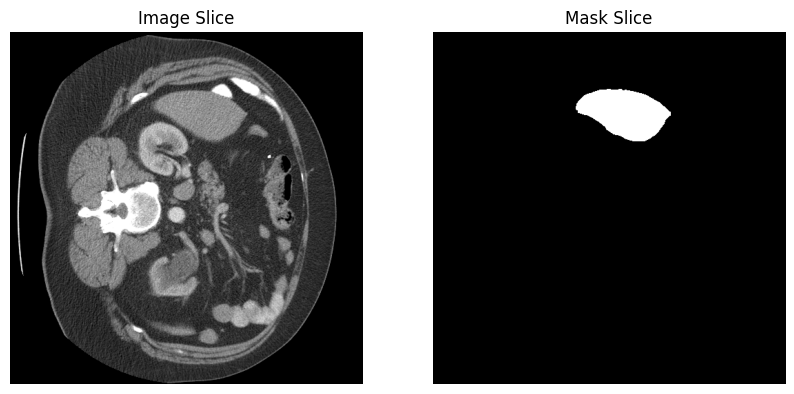

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_t[0], cmap="gray")
plt.title("Image Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_t[0], cmap="gray")
plt.title("Mask Slice")
plt.axis("off")
plt.show()

#### 1.2.3.1 Image Manipulation

In [ ]:
img_path = train_df.iloc[0]["img_path"]
mask_path = train_df.iloc[0]["mask_path"]

img = nib.load(img_path)
mask = nib.load(mask_path)

# Get the specific slice
img_array = img.dataobj[:, :, train_df.iloc[0]["begin_slice"] + 20].astype(
    np.float32
)  # (H, W)
mask_array = mask.dataobj[:, :, train_df.iloc[0]["begin_slice"] + 20].astype(
    np.float32
)  # (H, W)

In [18]:
print(img_path)

/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_022_0000.nii.gz


In [19]:
print(train_df.iloc[0]["organ"])

liver


In [20]:
img_array.shape

(512, 512)

Base CT Scans

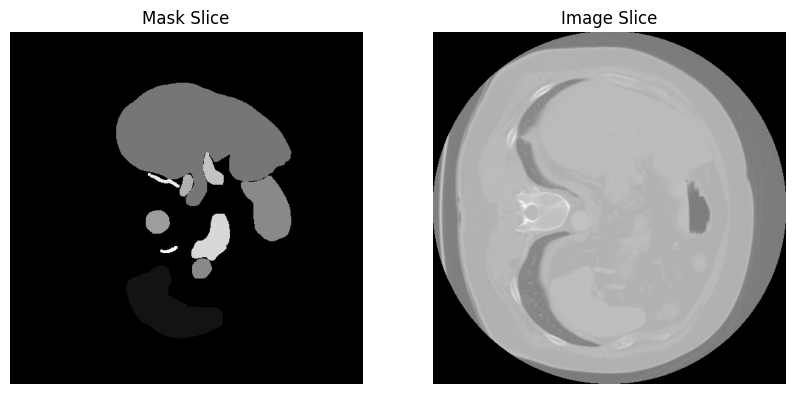

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_array, cmap="gray")
plt.title("Mask Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_array, cmap="gray")
plt.title("Image Slice")
plt.axis("off")
plt.show()

Clipped CT Scans

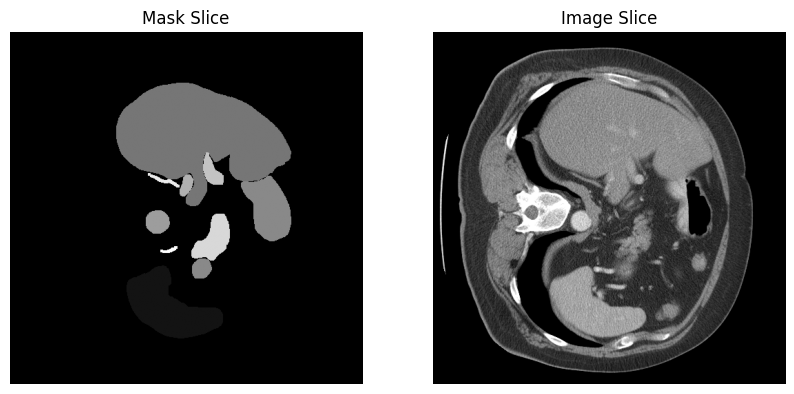

In [ ]:
def clip_and_rescale(ct_array, min_hu=-175, max_hu=250):
    clipped = np.clip(ct_array, min_hu, max_hu)
    return (clipped + abs(min_hu)) / (max_hu + abs(min_hu))


mask_slice = clip_and_rescale(mask_array)
img_slice = clip_and_rescale(img_array)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_slice, cmap="gray")
plt.title("Mask Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_slice, cmap="gray")
plt.title("Image Slice")
plt.axis("off")
plt.show()

## Testing

In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import torch
from train_model import BTCVSliceDataset
import os
import matplotlib.pyplot as plt

In [3]:
train_path = "/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/split/train_dataset.csv"
train_df = pd.read_csv(train_path)

In [9]:
organ_key = 8
mask_path = train_df.iloc[0]["mask_path"]
mask_nifti = nib.load(mask_path)
mask_data = mask_nifti.get_fdata()
binary_mask = (mask_data == organ_key).astype(np.float32)

In [ ]:
binary_mask_np = (
    torch.from_numpy(binary_mask).float().unsqueeze(0)
)  # Remove singleton dimensions
binary_mask_np.shape

torch.Size([1, 512, 512, 104])

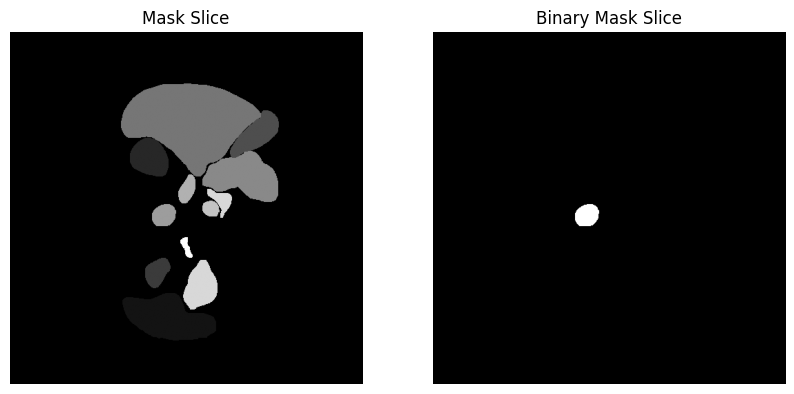

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_data[:, :, 70], cmap="gray")
plt.title("Mask Slice")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask_np[0][:, :, 70], cmap="gray")
plt.title("Binary Mask Slice")
plt.axis("off")
plt.show()

In [ ]:
def clip_and_rescale(ct_array, min_hu=-175, max_hu=250):
    clipped = np.clip(ct_array, min_hu, max_hu)
    return (clipped + abs(min_hu)) / (max_hu + abs(min_hu))


volume_path = train_df.iloc[0]["img_path"]
vol_nifti = nib.load(volume_path)
vol_data = vol_nifti.get_fdata()

vol_clipped = clip_and_rescale(vol_data)

In [13]:
vol_clipped.shape

(512, 512, 104)

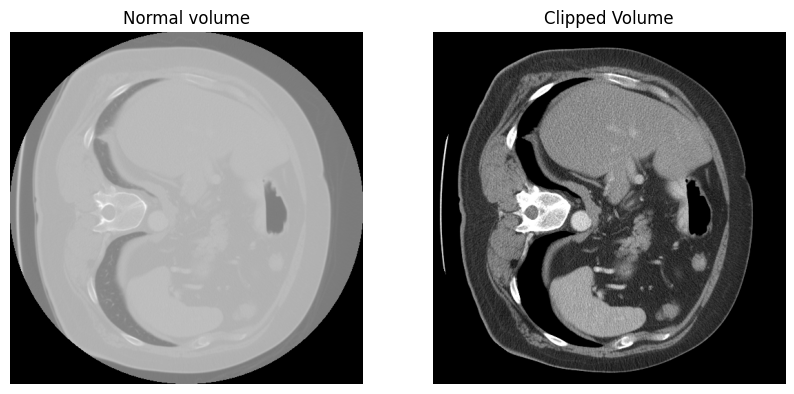

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol_data[:, :, train_df.iloc[0]["begin_slice"] + 20], cmap="gray")
plt.title("Normal volume")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(vol_clipped[:, :, train_df.iloc[0]["begin_slice"] + 20], cmap="gray")
plt.title("Clipped Volume")
plt.axis("off")
plt.show()

### Testing val normal

In [28]:
train_set = BTCVSliceDataset(train_df, "liver", organ_threshold=0.05)

Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.20it/s]


Total slices found: 949
Total slices kept: 860


In [29]:
vol_slice, mask_slice = train_set[0]

In [30]:
vol_slice.shape, mask_slice.shape

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [31]:
train_loader_1 = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

In [ ]:
for vol, mask in train_loader_1:
    print(f"Batch Volume shape: {vol.shape}, Mask shape: {mask.shape}")
    vol_squeezed = vol.squeeze()
    mask_squeezed = mask.squeeze()
    print(
        f"Batch Volume shape after squeeze: {vol_squeezed.shape}, Mask shape after squeeze: {mask_squeezed.shape}"
    )
    break

Batch Volume shape: torch.Size([8, 1, 512, 512]), Mask shape: torch.Size([8, 1, 512, 512])
Batch Volume shape after squeeze: torch.Size([8, 512, 512]), Mask shape after squeeze: torch.Size([8, 512, 512])


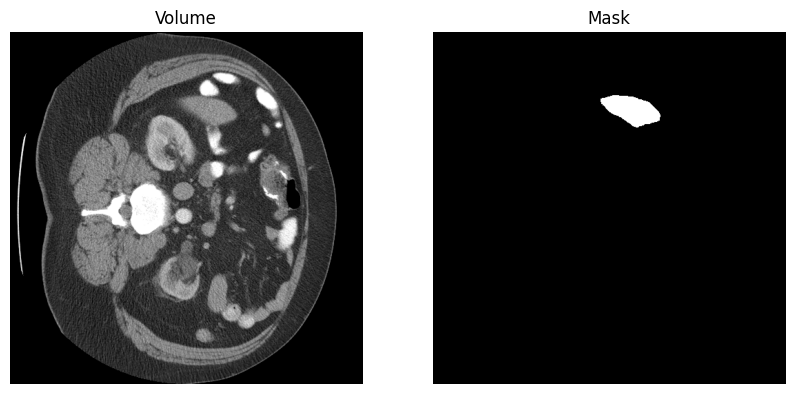

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol_slice[0], cmap="gray")
plt.title("Volume")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_slice[0], cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

### Testing val by patient

In [ ]:
import pandas as pd
from train_model import BTCVSliceDataset, VolumeCache

train_df = pd.read_csv(
    "/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/split/train_dataset.csv"
)
train_volume_cache = VolumeCache(train_df)
train_set = BTCVSliceDataset(
    train_df, "spleen", train_volume_cache, organ_threshold=0.05
)

Loading masks: 100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)

In [37]:
len(train_set.masks)

18

In [14]:
vol, mask = train_set[0]

In [15]:
vol.shape, mask.shape

(torch.Size([1, 512, 512, 104]), torch.Size([1, 512, 512, 104]))

In [16]:
vol_squeezed = vol.squeeze(0)
vol_squeezed.shape

torch.Size([512, 512, 104])

In [17]:
vol.shape[3]

104

In [ ]:
for idx in range(vol.shape[3]):
    vol_slice = vol[:, :, :, idx]
    mask_slice = mask[:, :, :, idx]
    print(vol_slice.shape, mask_slice.shape)
    vol_slice_np = vol_slice.numpy().squeeze(0)
    mask_slice_np = mask_slice.numpy().squeeze(0)
    print(vol_slice_np.shape, mask_slice_np.shape)
    break

torch.Size([1, 512, 512]) torch.Size([1, 512, 512])
(512, 512) (512, 512)


In [ ]:
vol[:, :, :, train_df.iloc[0]["begin_slice"] + 20].shape

torch.Size([1, 512, 512])

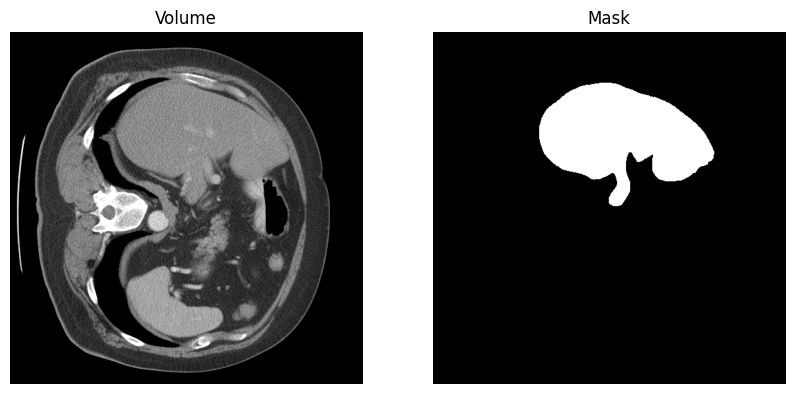

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol[0][:, :, train_df.iloc[0]["begin_slice"] + 20], cmap="gray")
plt.title("Volume")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask[0][:, :, train_df.iloc[0]["begin_slice"] + 20], cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

In [ ]:
import pandas as pd
from train_model import BTCVSliceDataset, VolumeCache

test_df = pd.read_csv(
    "/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/split/test_dataset.csv"
)
test_volume_cache = VolumeCache(test_df)
val_set = BTCVSliceDataset(test_df, "liver", test_volume_cache, by_patient=True)

Loading masks: 100%|██████████| 12/12 [00:01<00:00, 10.87it/s]


In [11]:
val_set[1].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
val_loader_1 = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, num_workers=4
)

In [23]:
val_loader_1

In [ ]:
i = 0
for vol, mask in val_loader_1:
    print(f"Batch {i+1}: Volume shape: {vol.shape}, Mask shape: {mask.shape}")
    vol_squeezed = vol.squeeze()
    mask_squeezed = mask.squeeze()
    print(
        f"Batch {i+1}: Volume shape: {vol_squeezed.shape}, Mask shape: {mask_squeezed.shape}"
    )
    i += 1
    for i in range(vol_squeezed.shape[2]):
        vol_slice = vol_squeezed[:, :, i]
        print(vol_slice.shape)
        mask_slice = mask_squeezed[:, :, i]
        print(mask_slice.shape)
        break
    break

Batch 1: Volume shape: torch.Size([1, 1, 512, 512, 117]), Mask shape: torch.Size([1, 1, 512, 512, 117])
Batch 1: Volume shape: torch.Size([512, 512, 117]), Mask shape: torch.Size([512, 512, 117])
torch.Size([512, 512])
torch.Size([512, 512])


## Visualization

In [2]:
import json

In [ ]:
with open(
    "results/thresh_variations/runs_20250627_172120/liver/eval_by_patient_metrics_liver.json",
    "r",
) as f:
    metrics = json.load(f)

print(metrics)

{'dice': [0.901975154876709, 0.8246181607246399, 0.9098407030105591, 0.9343975186347961, 0.9500712156295776, 0.9278168082237244, 0.9525392651557922, 0.7663150429725647, 0.9587498307228088, 0.8679972290992737, 0.8422923684120178, 0.8729985952377319], 'precision': [0.9565180339198326, 0.8332378032865748, 0.8916601621748749, 0.9165420536229603, 0.9563542666536828, 0.8900385500661309, 0.9510730145664329, 0.9199977956417704, 0.9464143750158478, 0.8053535536607767, 0.7540468955762974, 0.8281647279124497], 'recall': [0.8533170451788, 0.8161750699297193, 0.9287781099331823, 0.9529625325957688, 0.943870172505324, 0.9689442676971606, 0.9540100466678629, 0.6566275073051093, 0.9714110311104442, 0.9412081798763617, 0.9539299584867956, 0.9229645887488351], 'f1': [0.9019751598263995, 0.824618181910268, 0.9098407266163405, 0.93439753300383, 0.9500712105798576, 0.927816806993082, 0.9525392666325112, 0.7663150631279758, 0.9587498016817388, 0.8679972059881402, 0.8422923555234819, 0.8729985960960918]}


In [ ]:
metrics["dice"]

[0.901975154876709,
 0.8246181607246399,
 0.9098407030105591,
 0.9343975186347961,
 0.9500712156295776,
 0.9278168082237244,
 0.9525392651557922,
 0.7663150429725647,
 0.9587498307228088,
 0.8679972290992737,
 0.8422923684120178,
 0.8729985952377319]

In [ ]:
average_dice = sum(metrics["dice"]) / len(metrics["dice"])
average_dice

0.8924676577250162

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path


def generate_summary_table(results_directory):
    """
    Finds all patient-wise evaluation JSON files in a directory,
    calculates mean ± std for each metric, and returns a pandas DataFrame.
    """

    # Use Path to easily handle file paths
    root_path = Path(results_directory)

    # Use rglob to find all matching json files in the directory and its subdirectories
    json_files = list(root_path.rglob("eval_by_patient_metrics_*.json"))

    if not json_files:
        print(
            f"Error: No 'eval_by_patient_metrics_...' JSON files found in {root_path}"
        )
        return None

    # print(f"Found {len(json_files)} result files to process.")

    all_results = []

    # Loop through each JSON file found
    for file_path in json_files:
        # Extract the organ name from the filename
        # e.g., "eval_by_patient_metrics_liver.json" -> "liver"
        organ_name = file_path.stem.replace("eval_by_patient_metrics_", "")

        # This will hold the results for the current organ
        organ_summary = {"Organ": organ_name.capitalize()}

        with open(file_path, "r") as f:
            data = json.load(
                f
            )  # Load the dict, e.g., {"dice": [...], "precision": [...]}

            # Loop through each metric in the file (dice, precision, etc.)
            for metric, values in data.items():
                if metric == "f1":
                    continue
                if not values:  # Skip if the list of values is empty
                    continue

                # Calculate mean and standard deviation using NumPy
                mean = np.mean(values)
                std_dev = np.std(values)

                # Format into the "mean ± std" string
                # \u00B1 is the unicode character for the ± symbol
                formatted_string = f"{mean:.3f} \u00b1 {std_dev:.3f}"

                # Add it to our summary dictionary for this organ
                organ_summary[metric.capitalize()] = formatted_string

        all_results.append(organ_summary)

    # Convert the list of dictionaries into a pandas DataFrame
    if not all_results:
        print("No data was processed.")
        return None

    summary_df = pd.DataFrame(all_results)
    summary_df = summary_df.set_index("Organ")  # Use the organ name as the table index

    return summary_df

In [ ]:
path = "./results/thresh_variations/runs_20250627_172120"
metrics_005_df = generate_summary_table(path)
metrics_005_df.to_csv(f"{path}/metrics_summary_table.csv")
print("\nTable saved to final_summary_table.csv")
print(metrics_005_df)

Found 4 result files to process.

Table saved to final_summary_table.csv
                       Dice      Precision         Recall
Organ                                                    
Spleen        0.553 ± 0.124  0.417 ± 0.137  0.898 ± 0.091
Liver         0.892 ± 0.057  0.887 ± 0.065  0.905 ± 0.087
Left kidney   0.662 ± 0.072  0.554 ± 0.095  0.853 ± 0.108
Right kidney  0.680 ± 0.087  0.615 ± 0.097  0.816 ± 0.175


In [ ]:
root_path = Path("./results/thresh_variations")
loss_func = ["BCE", "Dice", "DiceBCE"]
thresh_list = [0.05, 0.1, 0.15]

for loss, folder in zip(loss_func, root_path.iterdir()):
    if folder.is_dir():
        # print(f"Processing folder: {folder}")
        metrics_df = generate_summary_table(folder)
        if metrics_df is not None:
            metrics_df.to_csv(folder / "metrics_summary_table.csv")
            print(f"for threshold {loss} :")
            print(metrics_df)
            # print(f"Saved summary table to {folder / 'metrics_summary_table.csv'}")
        else:
            print(f"No valid metrics found in {folder}")

for threshold 0.05 :
                       Dice      Precision         Recall
Organ                                                    
Spleen        0.633 ± 0.154  0.556 ± 0.185  0.807 ± 0.162
Liver         0.894 ± 0.060  0.884 ± 0.077  0.913 ± 0.084
Left kidney   0.710 ± 0.072  0.613 ± 0.119  0.883 ± 0.100
Right kidney  0.714 ± 0.117  0.675 ± 0.072  0.802 ± 0.202
for threshold 0.15 :
                       Dice      Precision         Recall
Organ                                                    
Spleen        0.553 ± 0.124  0.417 ± 0.137  0.898 ± 0.091
Liver         0.892 ± 0.057  0.887 ± 0.065  0.905 ± 0.087
Left kidney   0.662 ± 0.072  0.554 ± 0.095  0.853 ± 0.108
Right kidney  0.680 ± 0.087  0.615 ± 0.097  0.816 ± 0.175


In [ ]:
from train_model import BTCVSliceDataset
import pandas as pd
import os

organ_list = [
    "spleen",
    "liver",
    "right kidney",
    "left kidney",
]
data_path = "/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData"

organ_threshold = [0.05, 0.1, 0.15]  # Threshold for organ presence in slices
for threshold in organ_threshold:
    for organ in organ_list:
        train_set = pd.read_csv(os.path.join(data_path, "split", "train_dataset.csv"))
        train_set = BTCVSliceDataset(
            train_set,
            organ,
            organ_threshold=threshold,
        )

Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.12it/s]


Average white percentage for spleen: 0.0246
Total slices found: 555
Total slices kept: 533


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


Average white percentage for liver: 0.0652
Total slices found: 949
Total slices kept: 860


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


Average white percentage for right kidney: 0.0099
Total slices found: 548
Total slices kept: 538


Loading masks: 100%|██████████| 18/18 [00:01<00:00,  9.87it/s]


Average white percentage for left kidney: 0.0100
Total slices found: 556
Total slices kept: 543


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


Average white percentage for spleen: 0.0256
Total slices found: 555
Total slices kept: 512


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.08it/s]


Average white percentage for liver: 0.0713
Total slices found: 949
Total slices kept: 786


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.01it/s]


Average white percentage for right kidney: 0.0102
Total slices found: 548
Total slices kept: 521


Loading masks: 100%|██████████| 18/18 [00:01<00:00,  9.98it/s]


Average white percentage for left kidney: 0.0103
Total slices found: 556
Total slices kept: 528


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


Average white percentage for spleen: 0.0266
Total slices found: 555
Total slices kept: 493


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.08it/s]


Average white percentage for liver: 0.0770
Total slices found: 949
Total slices kept: 728


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.10it/s]


Average white percentage for right kidney: 0.0105
Total slices found: 548
Total slices kept: 509


Loading masks: 100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


Average white percentage for left kidney: 0.0106
Total slices found: 556
Total slices kept: 514


### Taking samples from classic test set

In [1]:
from test_btcv_classic import BTCVSliceDataset, VolumeCache
import pandas as pd
import os


dataset = pd.read_csv("/home/ieljamiy/RawData/split/test_dataset.csv")

train_set = dataset[dataset["patient_id"] == "img_003_0000.nii"]
val_set = dataset[dataset["patient_id"] == "img_020_0000.nii"]
test_set = dataset[dataset["patient_id"] == "img_000_0000.nii"]

train_volume_cache = VolumeCache(train_set)

train_dataset = BTCVSliceDataset(
    train_set,
    "right kidney",
    train_volume_cache,
    organ_threshold=0.1,
    binary=True,
)



Loading masks: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

Average white percentage for right kidney: 0.0162
Total slices found: 29
Total slices kept: 28


In [3]:
_, _, subset = train_dataset.sample_k_from_dataset(10)

In [4]:
subset

[{'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'slice_idx': 77},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'slice_idx': 80},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'slice_idx': 81},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'slice_idx': 84},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'slice_idx': 85},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ieljamiy/RawData/labelsTr/img_003.nii.gz',
  'slice_idx': 87},
 {'img_path': '/home/ieljamiy/RawData/imagesTr/img_003_0000.nii.gz',
  'mask